# Feature Engineering

## Load Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

## Load Processed Data

In [2]:
X = pd.read_csv("../Dataset/X_scaled.csv", index_col=0)
y = pd.read_csv("../Dataset/y_clean.csv", index_col=0).squeeze()

In [3]:
print(X.shape, y.shape)

(115294, 4) (115294,)


In [4]:
X.head()

,shunt_voltage,bus_voltage_V,current_mA,power_mW
time,,,,
2023-12-24 16:18:00,-0.739315,0.883579,-0.764058,-0.783712
2023-12-24 16:18:00,-0.054633,-0.221316,-0.064591,-0.032325
2023-12-24 16:18:00,-0.800175,0.607355,-0.779263,-0.783712
2023-12-24 16:18:00,-0.759602,0.883579,-0.784332,-0.783712
2023-12-24 16:18:00,-0.805247,0.607355,-0.728577,-0.704618


## Train/Validation/Test Split
In time series, we must avoid shuffling data randomly for train/val/test split because of temporal dependencies and the risk of look-ahead bias.

Choice of split: Given the time distribution in EDA, we might train on '2023/12/24 16:18:00'-'2023-12-26 14:01:00' and valid/test on '2023-12-26 14:04:00'–'2023/12/30 16:20:00' (approximately an 66/17/17 split by time). This ensures the test set simulates a forward-looking evaluation.

In [5]:
val_start = '2023-12-26 14:04:00'
val_index = X.index.get_loc(val_start)
val_index = val_index.start
print(f"Validation start index: {val_index}")

Validation start index: 75615


In [ ]:
# Split into train and temporary (val + test) sets
X_train = X[:val_index]
y_train = y[:val_index]

X_temp = X[val_index:]
y_temp = y[val_index:]

# Find split point for val and test (val gets one more if odd)
n_temp = len(X_temp)
val_size = (n_temp + 1) // 2
test_size = n_temp // 2

val_end_idx = val_size

# Split temp into validation and test
X_val = X_temp[:val_end_idx]
y_val = y_temp[:val_end_idx]

X_test = X_temp[val_end_idx:]
y_test = y_temp[val_end_idx:]

# Print sizes
total_size = len(X_train) + len(X_val) + len(X_test)
print("Train size:", len(X_train), "| Validation size:", len(X_val), "| Test size:", len(X_test))
print("Total size:", len(X_train) + len(X_val) + len(X_test))

train_proportion = len(X_train) / total_size
val_proportion = len(X_val) / total_size
test_proportion = len(X_test) / total_size

print(f"Train proportion: {train_proportion:.2f}")
print(f"Validation proportion: {val_proportion:.2f}")
print(f"Test proportion: {test_proportion:.2f}")

Train size: 75615 | Validation size: 19840 | Test size: 19839
Total size: 115294
Train proportion: 0.66
Validation proportion: 0.17
Test proportion: 0.17


In [7]:
# Check for split time period
print(X_train.iloc[-1])
print(X_val.iloc[0])

print(y_train.iloc[-1])
print(y_val.iloc[0])

shunt_voltage   -0.947255
bus_voltage_V    0.883579
current_mA      -0.814744
power_mW        -0.941898
Name: 2023-12-26 14:01:00, dtype: float64
shunt_voltage    1.786402
bus_voltage_V   -1.878659
current_mA       1.871616
power_mW         1.608860
Name: 2023-12-26 14:04:00, dtype: float64
0
1


## Feature Selection - Random Forest

### Hyperparameter Tuning with GridSearchCV (on RF)

In [8]:
# Defining the Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Setting up GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [9]:
# Finding the Best Random Forest Configuration
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
best_params = rf_grid.best_params_

print("Best hyperparameters found:")
print(best_params)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters found:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


### Evaluate on Validation Set

In [ ]:
# Evaluate on val set
y_val_pred = best_rf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, zero_division=1)

print("\nValidation Accuracy:", val_accuracy)
print("Validation F1-score:", val_f1)

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=1))


Validation Accuracy: 0.6626512096774193
Validation F1-score: 0.7934195499861106

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.04      0.08      6947
           1       0.66      1.00      0.79     12893

    accuracy                           0.66     19840
   macro avg       0.77      0.52      0.44     19840
weighted avg       0.74      0.66      0.54     19840



### Feature Importance Ranking

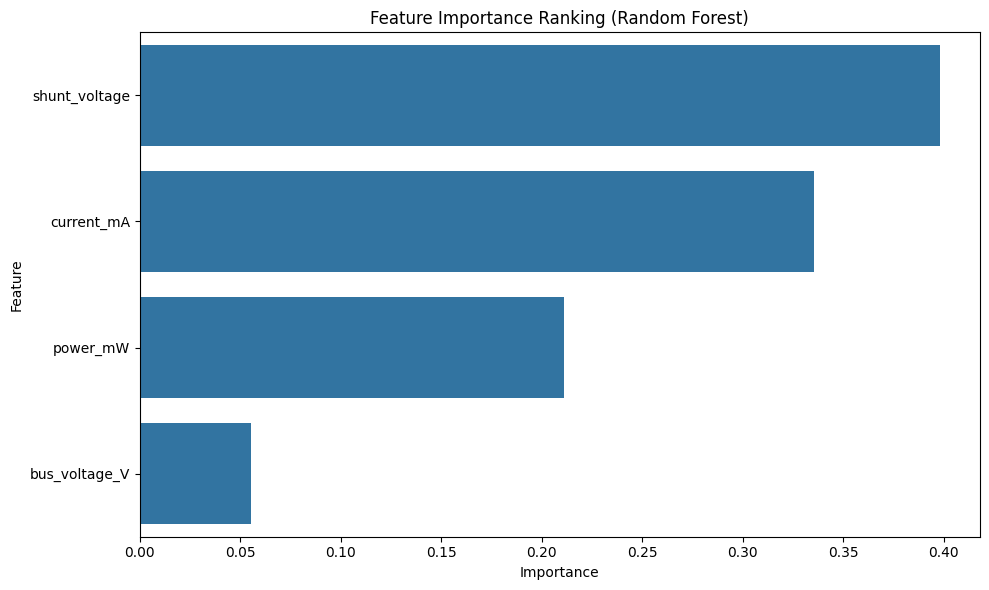

In [11]:
# Feature Importance Ranking
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature Importance Ranking
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance Ranking (Random Forest)")
plt.tight_layout()
plt.show()

## Final Evaluation on Test Set

In [ ]:
# Evaluate on test set
y_test_pred = best_rf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Check if both classes are present in y_test
if len(set(y_test)) > 1:
    auc_test = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
else:
    auc_test = None  # Cannot compute AUC when there is only one class in y_test

# Print results
print("\nTest Accuracy:", acc_test)
print("Test F1-score:", f1_test)
if auc_test is not None:
    print("Test AUC:", auc_test)
else:
    print("Test AUC: Cannot compute (only one class present in y_test)")


Test Accuracy: 0.968496395987701
Test F1-score: 0.98399610785343
Test AUC: Cannot compute (only one class present in y_test)


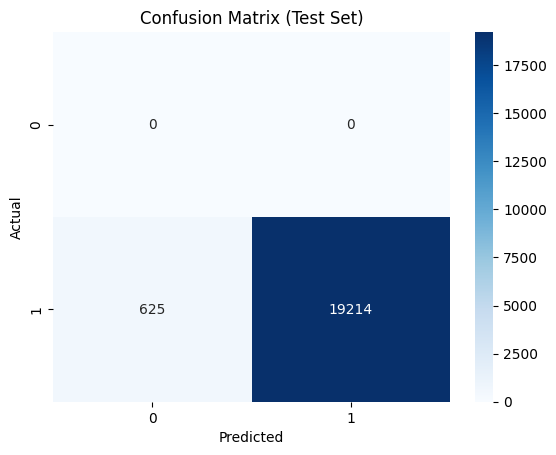

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Save Top N Features for MLP

In [15]:
# Create four feature sets based on importance thresholds
thresholds = {
    "all_features": X.columns.tolist(),
    "importance_gt_0.2": feature_importance_df[feature_importance_df['Importance'] > 0.2]['Feature'].tolist()
}

# Save each set of features and corresponding data
for name, selected_features in thresholds.items():
    print(f"\nSaving feature set: {name} ({len(selected_features)} features)")
    X_sel = X[selected_features]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
        X_sel, y, test_size=0.1, random_state=42, stratify=y
    )
    X_train_sel, X_val_sel, y_train_sel, y_val_sel = train_test_split(
        X_train_sel, y_train_sel, test_size=2/9, random_state=42, stratify=y_train_sel
    )


    X_train_sel.to_csv(f"../Dataset/MLP Data/X_train_{name}.csv", index=False)
    X_val_sel.to_csv(f"../Dataset/MLP Data/X_val_{name}.csv", index=False)
    X_test_sel.to_csv(f"../Dataset/MLP Data/X_test_{name}.csv", index=False)
    y_train_sel.to_csv(f"../Dataset/MLP Data/y_train_{name}.csv", index=False)
    y_val_sel.to_csv(f"../Dataset/MLP Data/y_val_{name}.csv", index=False)
    y_test_sel.to_csv(f"../Dataset/MLP Data/y_test_{name}.csv", index=False)



print("\nAll feature subsets saved for MLP training.")


Saving feature set: all_features (4 features)

Saving feature set: importance_gt_0.2 (3 features)

All feature subsets saved for MLP training.
